 # Opis notatnika
 Ten notatnik jest kontunacją analizy danych o lotach i ich opóźnieniach. Od tego momentu zaczniemy łączyć posiadana przez nas zbiory danych, będąc w stanie dokonać dodatkowych analiz.

 Zanim jednak do tego przejdziemy, należy, podobnie jak w poprzednim kroku, skonfigurować odpowiednio notatnik.

 Tutaj zaimportuj wymagane biblioteki

In [1]:
from sqlalchemy import create_engine
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import pandas as pd
import sys
sys.path.append('../')

pd.set_option("display.max_colwidth", 3000)
pd.set_option("display.max_columns", None)

%matplotlib inline


 ## Połączenie z bazą danych
 Tutaj uzupełnij konfigurację połączenia

In [2]:
from config.DB_connect import username, passwd, hostname, db_name, port

 Tutaj stwórz zmienną engine, która zostanie użyta do połączenia z bazą danych

In [3]:
url = f"postgresql://{username}:{passwd}@{hostname}:{port}/{db_name}"
engine = create_engine(url, echo=False)

 Tutaj uzupełnij implementację metody `read_sql_table`

In [4]:
def read_sql_table(table_name):
    return pd.read_sql(f"SELECT * FROM {table_name}", engine)

 Tutaj zaczytaj zapisaną wcześniej ramkę danych `flight_df` do zmniennej o takiej samej nazwie

In [5]:
flight_df = pd.read_csv("../data/processed/flight_01.csv", index_col=None)
flight_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6922924 entries, 0 to 6922923
Data columns (total 31 columns):
 #   Column               Dtype  
---  ------               -----  
 0   id                   int64  
 1   month                int64  
 2   day_of_month         int64  
 3   day_of_week          int64  
 4   op_unique_carrier    object 
 5   tail_num             object 
 6   op_carrier_fl_num    int64  
 7   origin_airport_id    int64  
 8   dest_airport_id      int64  
 9   crs_dep_time         int64  
 10  dep_time             float64
 11  dep_delay            float64
 12  dep_time_blk         object 
 13  crs_arr_time         int64  
 14  arr_time             float64
 15  arr_delay_new        float64
 16  arr_time_blk         object 
 17  cancelled            int64  
 18  crs_elapsed_time     float64
 19  actual_elapsed_time  float64
 20  distance             int64  
 21  distance_group       int64  
 22  year                 int64  
 23  carrier_delay        float64
 24

Sprawdzenie poprawności danych w ramce `flight_df` 

In [6]:
flight_df_expected_rows_amount = 6922924
flight_df_rows_amount = flight_df.shape[0]

assert (
    flight_df_rows_amount == flight_df_expected_rows_amount
), f"Oczekiwano {flight_df_expected_rows_amount} wierszy, otrzymano {flight_df_rows_amount}"

 # Wzbogacenie o `aircraft`
 Używając procedury `read_sql_table` wczytaj dane z tabeli `aircraft` i zapisz jako `aircraft_df`. Następnie:
 1. Usuń z ramki kolumny `number_of_seats` oraz `id`. Na tej podstawie usuń nadmiarowe wiersze (duplikaty).
 1. Następnie jeszcze raz sprawdź, czy dla kolumny `tail_num` nie występują duplikaty. Innymi słowy, należy sprawdzić, czy dla jednego `tail_num` występuje więcej niż jeden rok produkcji.
 1. Jeśli tak to:
     - do ramki `aircraft_df_duplicated` zapisz powielone zgodnie ze sprawdzeniem wiersze,
     - zgodnie z powyższym zmodyfikuj ramkę tak, aby w przypadku duplikatu za datę wytworzenia samolotu uznana została data najnowsza tj. jeśli dla `tail_num` są dostępne daty produkcji 1998 oraz 2001, uznajemy, że `tail_num` został wyprodukowany w `2001`.

 Wskazówki:
 - Praca z duplikatami na LMS: `Python - analiza danych -> Dzień 5 - Pandas -> Duplikaty`
 - Dokumentacja metody `duplicated`: [klik](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.duplicated.html)
 - Dokumentacja metody `drop_duplicates`: [klik](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop_duplicates.html)

 Tutaj wczytaj tabelę `aircraft` używając `read_sql_table`

In [7]:
aircraft_df = read_sql_table("aircraft")
aircraft_df.shape

(7383, 4)

 Tutaj usuń kolumnę `number_of_seats` oraz duplikaty z ramki `aircraft_df`

In [8]:
aircraft_df.drop(columns=["id", "number_of_seats"], inplace=True)

In [9]:
aircraft_df[aircraft_df.duplicated()]

,manufacture_year,tail_num
845,1993,N399CM
1213,1997,N1439A
1547,1999,N1049A
1733,1999,N781CA
2108,2000,N854AS
2110,2000,N856AS
2112,2000,N860AS
2512,2001,N862AS
2516,2001,N868AS
2521,2001,N881AS


In [10]:
aircraft_df.drop_duplicates(inplace=True)
aircraft_df.shape

(7364, 2)

 ### Sprawdzenie
 Uruchom kod poniżej, aby sprawdzić, czy ta część została poprawnie wykonana

In [11]:
aircraft_df_expected_rows = 7364
aircraft_df_expected_columns = set(["tail_num", "manufacture_year"])

aircraft_df_rows = aircraft_df.shape[0]

diff = aircraft_df_expected_columns.symmetric_difference(
    set(aircraft_df.columns))
assert (
    aircraft_df_rows == aircraft_df_expected_rows
), f"Spodziewano się {aircraft_df_expected_rows} wierszy , otrzymano {aircraft_df_rows} wierszy"

assert diff == set(
    []
), f"Spodziewano się {aircraft_df_expected_columns} kolumn, otrzymano: {aircraft_df_expected_columns} kolumn. Różnica: \n\t{diff}"

 Tutaj sprawdź, czy w ramkce `aircraft_df` występują duplikaty wewnątrz kolumny `tail_num`. Czyli czy dla danego `tail_num` występuje więcej niż jeden rok produkcji.

In [12]:
aircraft_df_duplicated = aircraft_df[aircraft_df["tail_num"].duplicated()]

 ### Sprawdzenie
 Uruchom kod poniżej, aby sprawdzić, czy ta część została poprawnie wykonana

In [13]:
aircraft_df_expected_rows = 3
aircraft_df_duplicated_rows = aircraft_df_duplicated.shape[0]
assert (
    aircraft_df_duplicated_rows == aircraft_df_expected_rows
), f"Oczekiwano {aircraft_df_expected_rows} wierszy, otrzymano {aircraft_df_duplicated_rows}"

 ## Modyfikacja `aircraft_df`
 Tutaj dokonaj aktualizacji tabeli `aircraft_df` - jeśli jest taka potrzeba. Zrób to tak aby, dla powielonych `tail_num`, `manufacture_year` został ustawiony jako najwyższy

In [14]:
aircraft_df.drop_duplicates(subset="tail_num", keep="last", inplace=True)
aircraft_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7361 entries, 0 to 7382
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   manufacture_year  7361 non-null   int64 
 1   tail_num          7361 non-null   object
dtypes: int64(1), object(1)
memory usage: 172.5+ KB


 ### Sprawdzenie
 Uruchom kod poniżej, aby sprawdzić, czy ta część została poprawnie wykonana

In [15]:
test_tail = "N783CA"
test_value = aircraft_df.loc[aircraft_df["tail_num"]
                             == test_tail]["manufacture_year"].iloc[0]
test_value = int(test_value)

expected_value = 2000
assert (
    test_value == expected_value
), f"Dla 'tail_num' == '{test_tail}' oczekiwano {expected_value} otrzymano {test_value}"

 ## Połączenie `aircraft_df` oraz `flight_df`
 Połącz ramkę `aircraft_df` oraz `flight_df` zgodnie z kluczem oraz odpowiedz na następujące pytania:
 1. Czy po połączeniu pojawiły się duplikaty? Dokonaj odpowiedniego sprawdzenia.
 1. Wyznacz zależność roku produkcji do częstotliwości opóźnień. Wynik zapisz do tabeli `delays_by_manufacture_year_df`.
 1. Przedstaw wyniki w tabeli za pomocą wykresu punktowego.
 1. Dokonaj modyfikacji w taki sposób, aby wyświetlone na wykresie zostały tylko takie roczniki samolotów, które wykonały łącznie więcej niż 10000 `(>)` lotów.

> **Wskazówka:**
> Aby nie utracić potencjalnie całej dotychczasowej pracy, zapisz wynik do tymczasowej zmiennej np. `tmp_flight_df`. Po sprawdzeniu możesz użyć metody `copy`: [link](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.copy.html), aby nadpisać `flight_df` używając `tmp_flight_df`.

 Tutaj dokonaj złączenia `flight_df` z `aircraft_df`, wynik zapisz do `tmp_flight_df`

In [16]:
tmp_flight_df = pd.merge(
    left=flight_df, right=aircraft_df, how="left", on="tail_num")

 Tutaj dokonaj sprawdzenia, czy nie pojawiły się duplikaty

In [17]:
tmp_flight_df[tmp_flight_df.duplicated()]

,id,month,day_of_month,day_of_week,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,dest_airport_id,crs_dep_time,dep_time,dep_delay,dep_time_blk,crs_arr_time,arr_time,arr_delay_new,arr_time_blk,cancelled,crs_elapsed_time,actual_elapsed_time,distance,distance_group,year,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,is_delayed,is_weekend,distance_agg,manufacture_year


 Tutaj nadpisz `flight_df` używając `tmp_flight_df`

In [18]:
flight_df.shape[0] == 6922924

True

In [19]:
tmp_flight_df.shape[0] == 6922924

True

In [20]:
flight_df = tmp_flight_df.copy()
flight_df.shape[0] == 6922924

True

 ## Opóźnienia vs. rok produkcji samolotu cz. 1
 Tutaj wyznacz zależność roku produkcji do częstotliwości opóźnień

In [21]:
delays_by_manufacture_year_df = flight_df.groupby("manufacture_year", as_index=False).agg({"is_delayed": ["sum", "count"]})
delays_by_manufacture_year_df

manufacture_year is_delayed        
                           sum   count
0            1987.0        380    3720
1            1988.0        601    5189
2            1989.0         14      40
3            1990.0       2905   24017
4            1991.0       5541   38696
5            1992.0       9181   63888
6            1993.0       3989   23309
7            1994.0       4718   21450
8            1995.0       4766   25468
9            1996.0       6228   36291
10           1997.0       8276   42250
11           1998.0      34732  188929
12           1999.0      51362  283932
13           2000.0      60410  347435
14           2001.0      81644  476255
15           2002.0      64078  349379
16           2003.0      64215  348849
17           2004.0      87564  455817
18           2005.0      72960  380789
19           2006.0      58780  297710
20           2007.0      51121  278653
21           2008.0      49732  272396
22           2009.0      32868  169684
23           2010.0      24713  127001
24           2011.0      27698  135139
25           2012.0      28042  144775
26           2013.0      38543  218088
27           2014.0      60077  357383
28           2015.0      60395  343189
29           2016.0      68473  404788
30           2017.0      56100  325832
31           2018.0      47724  283416
32           2019.0      19960  123135

 Tutaj wyrysuj ramkę `delays_by_manufacture_year_df`

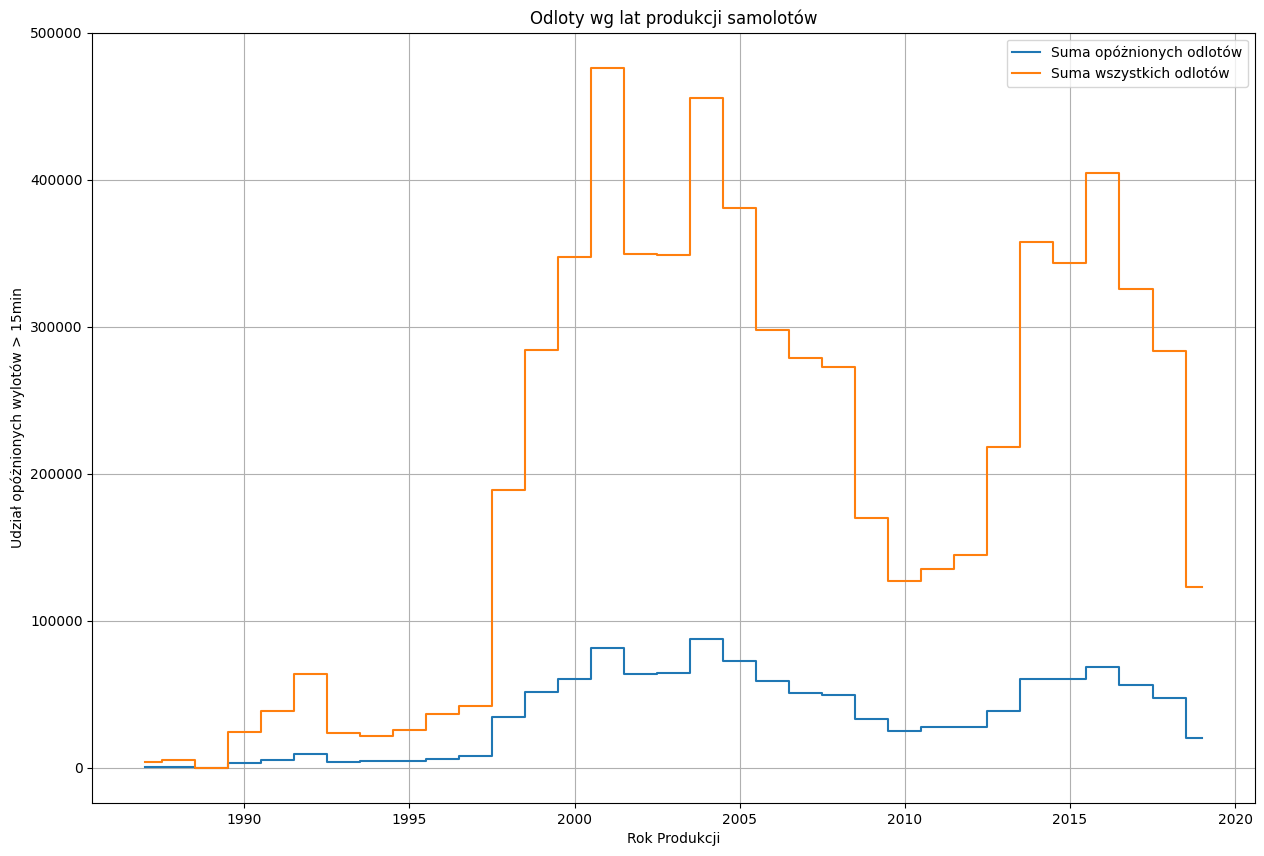

In [22]:
plt.figure(figsize=(15, 10))

fig1 = plt.plot(
    delays_by_manufacture_year_df.manufacture_year,
    delays_by_manufacture_year_df.is_delayed["sum"],
    drawstyle="steps-mid",
    label=("Suma opóżnionych odlotów"),
)

fig2 = plt.plot(
    delays_by_manufacture_year_df.manufacture_year,
    delays_by_manufacture_year_df.is_delayed["count"],
    drawstyle="steps-mid",
    label=("Suma wszystkich odlotów"),
)

plt.xlabel("Rok Produkcji")
# plt.xticks(flight_delays_by_distance_agg_df['distance_agg'].to_string())
plt.ylabel("Udział opóżnionych wylotów > 15min")
plt.title("Odloty wg lat produkcji samolotów")
plt.legend()

plt.grid(axis="both")
plt.show()

 Tutaj zmodyfikuj wykres tak, aby prezentował tylko te roczniki, które odbyły więcej niż 10 000 lotów

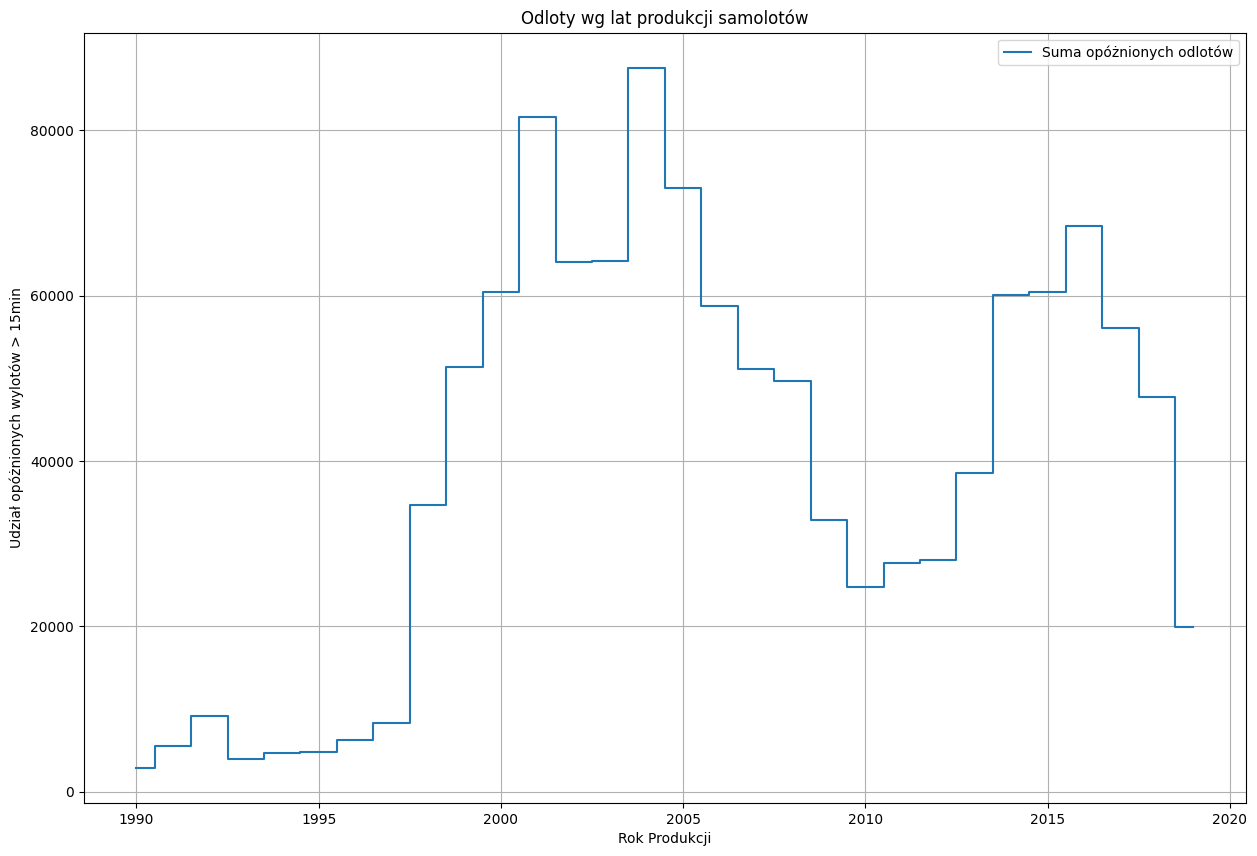

In [23]:
plt.figure(figsize=(15, 10))
delays_temp = delays_by_manufacture_year_df[
    delays_by_manufacture_year_df.is_delayed["count"] > 10000
]

fig1 = plt.plot(
    delays_temp.manufacture_year,
    delays_temp.is_delayed["sum"],
    drawstyle="steps-mid",
    label=("Suma opóżnionych odlotów"),
)

plt.xlabel("Rok Produkcji")
# plt.xticks(flight_delays_by_distance_agg_df['distance_agg'].to_string())
plt.ylabel("Udział opóżnionych wylotów > 15min")
plt.title("Odloty wg lat produkcji samolotów")
plt.legend()

plt.grid(axis="both")
plt.show()

 ## Opóźnienia vs. rok produkcji samolotu cz. 2
 Dokonaj agregacji kolumny `manufacture_year` do kolumny `manufacture_year_agg` zgodnie z poniższym:
 1. Grupując dane co 3 lata -> Czy po grupowaniu można zauważyć zależność? Wyniki zapisz do ramki `flight_delays_by_manufacture_year_agg_df`.
 1. Wyznacz top 5 roczników samolotu, które wykonały najwięcej lotów. Wyniki zapisz do ramki `top_manufactured_df`, do obliczeń wykorzystaj `delays_by_manufacture_year_df`.

 Tutaj dodaj kolumnę `manufacture_year_agg` do ramki `flight_df`

In [24]:
flight_df["manufacture_year_agg"] = pd.cut(
    flight_df.manufacture_year,
    bins=range(
        int(flight_df.manufacture_year.min()),
        int(flight_df.manufacture_year.max()) + 3,
        3,
    ),
)
flight_df[["manufacture_year", "manufacture_year_agg"]]

,manufacture_year,manufacture_year_agg
0,2008.0,"(2005.0, 2008.0]"
1,2004.0,"(2002.0, 2005.0]"
2,NaN,NaN
3,2004.0,"(2002.0, 2005.0]"
4,2004.0,"(2002.0, 2005.0]"
...,...,...
6922919,2002.0,"(1999.0, 2002.0]"
6922920,2002.0,"(1999.0, 2002.0]"
6922921,2016.0,"(2014.0, 2017.0]"
6922922,2001.0,"(1999.0, 2002.0]"


 Tutaj stwórz zmienną `flight_delays_by_manufacture_year_agg_df`

In [31]:
flight_delays_by_manufacture_year_agg_df = flight_df.groupby("manufacture_year_agg", as_index=False, observed=False).agg({"is_delayed": ["sum", "count"]})
flight_delays_by_manufacture_year_agg_df

manufacture_year_agg is_delayed         
                               sum    count
0          (1987, 1990]       3520    29246
1          (1990, 1993]      18711   125893
2          (1993, 1996]      15712    83209
3          (1996, 1999]      94370   515111
4          (1999, 2002]     206132  1173069
5          (2002, 2005]     224739  1185455
6          (2005, 2008]     159633   848759
7          (2008, 2011]      85279   431824
8          (2011, 2014]     126662   720246
9          (2014, 2017]     184968  1073809
10         (2017, 2020]      67684   406551

 Tutaj stwórz wykres w oparciu o dane zawarte w `flight_delays_by_manufacture_year_agg_df`

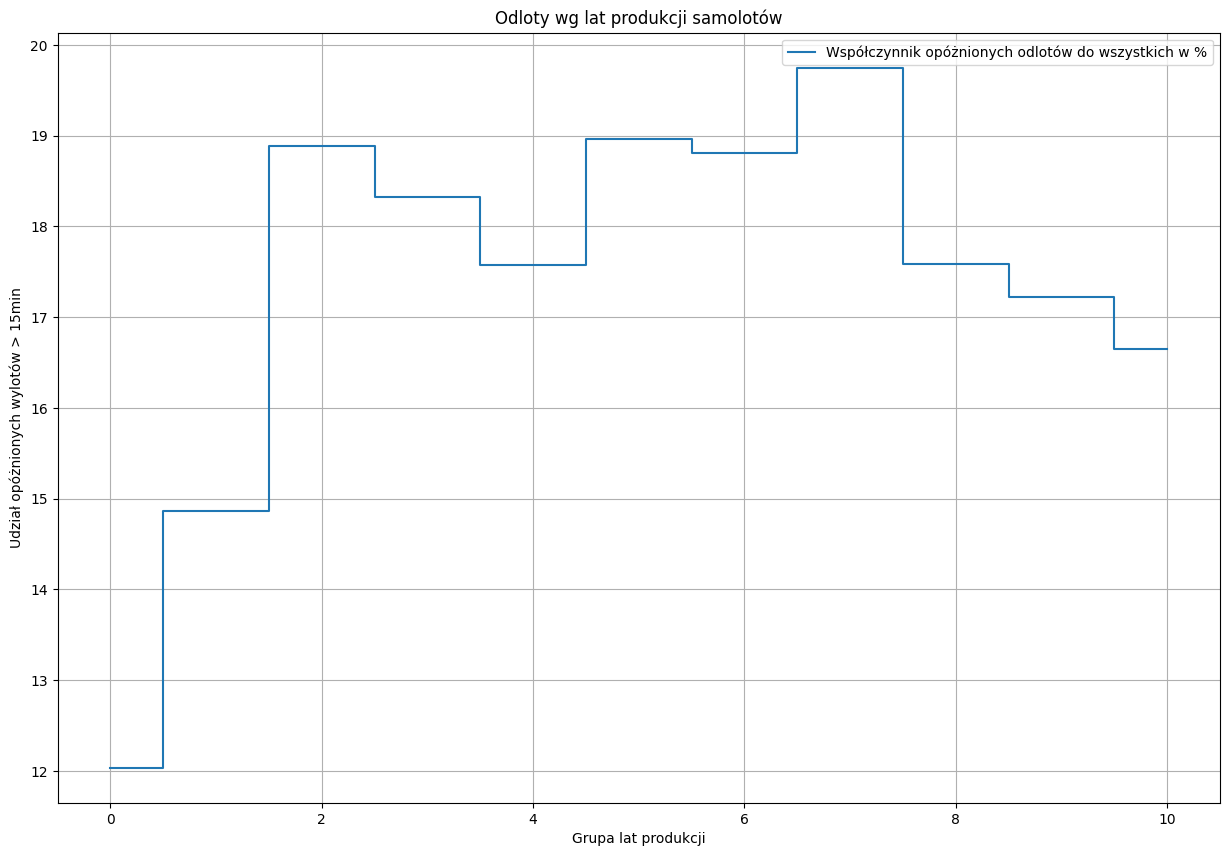

In [26]:
plt.figure(figsize=(15, 10))

plt.plot(
    flight_delays_by_manufacture_year_agg_df.index,
    (
        flight_delays_by_manufacture_year_agg_df.is_delayed["sum"]
        / flight_delays_by_manufacture_year_agg_df.is_delayed["count"]
    )
    * 100,
    drawstyle="steps-mid",
    label=("Współczynnik opóżnionych odlotów do wszystkich w %"),
)


plt.xlabel("Grupa lat produkcji")
plt.xticks=(flight_delays_by_manufacture_year_agg_df[('manufacture_year_agg',      '')])
plt.ylabel("Udział opóżnionych wylotów > 15min")
plt.title("Odloty wg lat produkcji samolotów")
plt.legend()

plt.grid(axis="both")
plt.show()

 Tutaj wyznacz TOP 5 roczników samolotów

In [27]:
delays_by_manufacture_year_df.set_index("manufacture_year", inplace=True)

# Najwiecej lotów wg lat produkcji

In [28]:
delays_by_manufacture_year_df.is_delayed.sort_values(
    "count", ascending=False).head(5)

,sum,count
manufacture_year,,
2001.0,81644,476255
2004.0,87564,455817
2016.0,68473,404788
2005.0,72960,380789
2014.0,60077,357383


# Najmniej opóżnień wg lat produkcji 

In [29]:
delays_by_manufacture_year_df["factor"] = (
    delays_by_manufacture_year_df.is_delayed["sum"]
    / delays_by_manufacture_year_df.is_delayed["count"]
)
delays_by_manufacture_year_df.sort_values("factor", ascending=True).head(5)

is_delayed           factor
                        sum  count          
manufacture_year                            
1987.0                  380   3720  0.102151
1988.0                  601   5189  0.115822
1990.0                 2905  24017  0.120956
1991.0                 5541  38696  0.143193
1992.0                 9181  63888  0.143705

 # Podsumowanie
 W tym notatniku do naszej wyjściowej ramki danych `flight_df` dołączyliśmy tabelę `aircraft_df` i za jej pomocą dodaliśmy kolejny wymiar do naszej analizy. Zauważmy, ile dodatkowych wniosków mogliśmy wyciągnąć dzięki jej dodaniu.

 Zanim przejdziemy dalej, należy zapisać bieżącą postać ramki (najlepiej lokalnie), która zostanie użyta w kolejnym notatniku.

 > **Wskazówka:**  
 > Aby uniknąć potencjalnych problemów, najlepiej zapisać ramkę z nazwą nawiązującą do tego notatnika, np. `flight_df_01`.

 Tutaj zapisz ramkę w najdogodniejszy sposób.

In [30]:
flight_df.to_csv("../data/processed/flight_02.csv", index=False)
flight_df.shape[0] == 6922924

True